In [1]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd


plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/statsmodels/tools/tools.py:6: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  import scipy.linalg


In [2]:
import json


data = pd.read_pickle("result/part1/data.pkl")
cofounders = ["assessment_center", "age", "sex", *[f"PC{i}" for i in range(1, 11)]]

In [3]:
proteomics_start = data.columns.tolist().index("C3")
proteomics = data.columns[proteomics_start:].tolist()
print(proteomics)
print(len(proteomics))

['C3', 'KLK7', 'GCHFR', 'NHLRC3', 'APOD', 'GAPDH', 'TP53I3', 'CPA4', 'ANXA2', 'GRSF1', 'IL25', 'HMMR', 'MRPL52', 'PAIP2B', 'THAP12', 'FOS', 'FGF9', 'PITHD1', 'THSD1', 'PTGES2', 'DEFB103A_DEFB103B', 'ATP1B4', 'CYB5A', 'UNC79', 'SLC34A3', 'TAGLN3', 'SLIRP', 'CLASP1', 'PSMC3', 'KIR3DL2', 'BEX3', 'PFDN4', 'BCL7A', 'SMC3', 'SLC28A1', 'CDC123', 'GJA8', 'NMRK2', 'GATA3', 'CPLX2', 'RASGRF1', 'FGF7', 'ANKRA2', 'RBM25', 'LYZL2', 'CDK1', 'CREB3', 'CREBZF', 'IGLON5', 'SHC1', 'ZP4', 'TMOD4', 'CEP152', 'MYH7B', 'CEP350', 'CDC25A', 'TRIM26', 'MANEAL', 'MUCL3', 'GIMAP8', 'CYTH3', 'PDXDC1', 'CLINT1', 'MAPRE3', 'EVI2B', 'STAU1', 'PCNA', 'DNAJA1', 'JMJD1C', 'GAGE2A', 'GAD1', 'IZUMO1', 'PDCL2', 'PDE1C', 'STOML2', 'BSND', 'MAPK13', 'PDIA2', 'BTLA', 'MLLT1', 'TPRKB', 'ARHGAP5', 'BTNL10', 'PHLDB2', 'PDIA5', 'ATF4', 'PRAME', 'TOP1MT', 'KHDC3L', 'DCUN1D2', 'IL3', 'DCLRE1C', 'ERCC1', 'DCDC2C', 'VCPKMT', 'SPRING1', 'MORN4', 'ESPL1', 'H2AP', 'MORF4L2', 'SSH3', 'VWA5A', 'PBK', 'REST', 'SHD', 'TXNL1', 'TPM3', 'NEB'

In [4]:
## 添加时间


def add_k_year_follow(df, k=5, unit="month"):

    assert unit in ["month", "year", "day"]
    year_of_cad_after_recuit = "year_of_cad_after_recuit"
    E = f"{k}_years_cad"
    T = f"{k}_years_cad_{unit}"

    df[E] = (df[year_of_cad_after_recuit] <= k).astype(int)

    def survive_time(x):
        cad_date = x["cad_date"]
        death_date = x["death_date"]
        recuit_date = x["recuit_date"]

        if x[E] == 1:  # K年内得了冠心病
            days = (cad_date - recuit_date).days
        elif x[E] == 0:  # K年没有冠心病
            if pd.notnull(death_date):
                death_times_after_recuit = (death_date - recuit_date).days
                if death_times_after_recuit <= k * 365:  # K年内死亡了
                    days = death_times_after_recuit
                else:
                    days = k * 365  # 死亡了，但是没在k年内
            else:
                days = k * 365  # 直到隨訪結束也沒有死
        if unit == "month":
            return days / 30
        elif unit == "year":
            return days / 365
        else:
            return days

    df[T] = df.apply(survive_time, axis=1)
    return df, E, T


data, E_3, T_3 = add_k_year_follow(data, k=3)
data, E_5, T_5 = add_k_year_follow(data, k=5)
data, E_10, T_10 = add_k_year_follow(data, k=10)

## age bin 划分

In [5]:
# data["age_bin"] = pd.cut(
#     data["age"],
#     bins=[0, 45, 50, 55, 60, 65, 70],
#     labels=["0-45", "45-50", "50-55", "55-60", "60-65", "65-70"],
# )

# data.groupby(["age_bin"]).value_counts(["incident_cad"])

In [6]:
data["age_bin"] = pd.cut(
    data["age"],
    bins=[0, 60, 65, 70],
    labels=["0-60", "60-65", "65-70"],
)

data.groupby(["age_bin"]).value_counts(["incident_cad"])

age_bin  incident_cad
0-60     0.0             30132
         1.0              1074
60-65    0.0             11183
         1.0               893
65-70    0.0              7292
         1.0               865
dtype: int64

In [7]:
data.groupby(["age_bin"]).value_counts([E_3])

age_bin  3_years_cad
0-60     0              31034
         1                172
60-65    0              11894
         1                182
65-70    0               8006
         1                151
dtype: int64

In [8]:
data.groupby(["age_bin"]).value_counts([E_5])

age_bin  5_years_cad
0-60     0              30860
         1                346
60-65    0              11744
         1                332
65-70    0               7858
         1                299
dtype: int64

In [9]:
data.groupby(["age_bin"]).value_counts([E_10])

age_bin  10_years_cad
0-60     0               30394
         1                 812
60-65    0               11362
         1                 714
65-70    0                7474
         1                 683
dtype: int64

## 基本变量配置

In [10]:
Part4_save_path = "result/part4"

association_output_path = f"{Part4_save_path}/1_age_specific_association"
# json_out_path = f"{association_output_path}/age_specific.json"

## 关联分析

In [ ]:
from ppp_prediction.corr import cal_corr, generate_multipletests_result


save_dir = association_output_path

cofounders = ["assessment_center", "age", "sex", *[f"PC{i}" for i in range(1, 11)]]


res = []
for label in ["incident_cad", E_3, E_5, E_10]:
    
    for age_bin, age_bin_df in data.groupby("age_bin"):
        c_save_dir = f"{save_dir}/{label}/{age_bin}.csv"
        Path(c_save_dir).parent.mkdir(parents=True, exist_ok=True)
        if Path(c_save_dir).exists():
            print(f"{c_save_dir} exists")
            continue
        print(f"age_bin: {age_bin}, label: {label}")
        single_association_proteins_result_df = cal_corr(
            age_bin_df, proteomics, y=label, cofounders=cofounders, model_type="logit"
        )  # 使用原始没有imputated版本

        single_association_proteins_result_df["LOG10P"] = -np.log10(
            single_association_proteins_result_df["pvalue"].astype(float)
        )

        single_association_proteins_result_df = generate_multipletests_result(
            single_association_proteins_result_df
        )
        single_association_proteins_result_df["age_bin"] = age_bin
        single_association_proteins_result_df["label"] = label
        single_association_proteins_result_df.sort_values(
            "LOG10P", ascending=False
        ).reset_index(drop=True).reset_index(drop=False, names="rank")
        single_association_proteins_result_df.to_csv(c_save_dir, index=False)

        res.append(single_association_proteins_result_df)

res_df = pd.concat(res)
res_df.to_csv(f"{save_dir}/all.csv", index=False)

### 火山图


In [ ]:
# 绘制火山图
for label in ["incident_cad", E_3, E_5, E_10]:
    for age_bin, age_bin_df in data.groupby("age_bin"):
        print(
            f"vocano.R -i {association_output_path}/{label}/{age_bin}.csv -o {association_output_path}/{label}/{age_bin} -x coef -y pvalue --runfdr --title {label}_{age_bin}"
        )

### KEGG

In [ ]:
from ppp_prediction.corr import generate_multipletests_result

sig_Assoc_save_dir = f"{Part4_save_path}/2_age_specific_Sig_association_result/"
Path(sig_Assoc_save_dir).mkdir(parents=True, exist_ok=True)

sig_Assoc_files = [
    generate_multipletests_result(pd.read_csv(i))
    .query("reject == True")
    .reset_index(drop=True)
    for i in Path(f"{association_output_path}/").rglob("*.csv")
    if i.name != "all.csv"
]

for corr_file_sig in sig_Assoc_files:
    to_dir = f"{sig_Assoc_save_dir}/{corr_file_sig['exposure'].values[0]}/{corr_file_sig['age_bin'].values[0]}.csv"
    Path(to_dir).parent.mkdir(parents=True, exist_ok=True)
    print(f"Saving to {to_dir}")
    corr_file_sig.to_csv(to_dir, index=False)

In [ ]:
len(sig_Assoc_files)

In [ ]:
for sigAssoc in Path(sig_Assoc_save_dir).rglob("*.csv"):
    # !echo "KEGG.R -f {sigAssoc} -o {sigAssoc.with_suffix("")} --title {sigAssoc.parent.stem}_{sigAssoc.stem}"
    !KEGG.R -f {sigAssoc} -o {sigAssoc.with_suffix("")} --title {sigAssoc.parent.stem}_{sigAssoc.stem}

## 单独模型构建

这部分只针对incident_cad对年龄区间进行模型构建；并且基于关联分析筛选后的蛋白进行

In [31]:
train_imputed = pd.read_pickle("result/part1/train_imputed.pkl")
test_imputed = pd.read_pickle("result/part1/test_imputed.pkl")

proteomics = test_imputed.columns[test_imputed.columns.tolist().index("C3") :].tolist()
test_imputed

eid       PRS  sex  height  weight       BSA  genotype_array  \
19409  2883530.0  1.030583  1.0   171.0    64.2  1.746282               2   
19272  2867444.0  2.192278  0.0   165.0    55.8  1.599219               2   
49865  5869793.0  0.653794  1.0   171.0    77.3  1.916181               2   
39664  4880838.0  0.664819  0.0   163.0    84.4  1.954852               2   
30555  3987428.0  0.826465  0.0   164.0    73.1  1.824859               1   
...          ...       ...  ...     ...     ...       ...             ...   
43327  5241912.0  1.085083  1.0   176.0   116.0  2.381409               2   
29129  3851862.0  1.294348  0.0   169.0    72.9  1.849932               2   
1550   1144512.0  0.722791  1.0   191.0    96.6  2.263883               1   
1888   1177099.0  1.335307  1.0   175.0    75.1  1.910679               2   
29456  3881441.0  1.055519  0.0   161.0    58.3  1.614715               2   

        age      PC1        PC2        PC3       PC4        PC5       PC6  \
19409  44.0  71.3002 -100.66700  81.855800  9.994410  -0.516576  4.576150   
19272  53.0 -12.4815    3.16181  -3.999700  0.309314  -6.865420 -1.982800   
49865  62.0 -11.4721    2.20519   0.205421 -1.035540  -2.391010 -2.383070   
39664  62.0 -11.1640    3.66252  -5.106300  2.058800   0.185104 -1.089780   
30555  66.0 -11.4666    2.77498  -0.076815  1.956800  -3.117790  1.036540   
...     ...      ...        ...        ...       ...        ...       ...   
43327  45.0 -10.8083    4.46241  -3.407760  0.549259  -3.142720 -1.816660   
29129  40.0 -12.6549    3.40064  -3.637290 -1.102990  -6.000440 -0.391299   
1550   59.0 -12.7237    1.46547  -0.964256  0.600405   4.758100 -1.273080   
1888   63.0 -15.1573    7.36690  -4.163850 -0.749832  -9.753590 -1.309890   
29456  53.0 -12.4170    4.44358   1.595030  4.310980  14.360700  0.618842   

            PC7       PC8        PC9       PC10  assessment_center  \
19409  1.832860  5.045020   1.614310  18.488800                  4   
19272 -1.245250  1.828070  -4.040440  -0.823290                 11   
49865  0.886641 -0.934631   1.414580   1.704540                  9   
39664  0.567691 -2.982090 -11.959100  -1.167040                 12   
30555 -0.677142 -1.716000  -5.479400   1.998590                  8   
...         ...       ...        ...        ...                ...   
43327 -0.497610 -0.022318  -5.462610   2.646430                 15   
29129 -0.086262  1.749640  -0.649827   1.585260                  2   
1550   2.218810  0.648162  -5.390120   0.535409                 12   
1888  -2.070880 -5.465710   6.209610   3.183450                 20   
29456 -1.265730  0.353728   0.951739   1.532330                  9   

       age_squared      BMI  dbp_a       sbp_a      tc_a      tg_a     hdl_a  \
19409       1936.0  21.9555   76.0  115.000000  5.851000  0.893000  1.635000   
19272       2809.0  20.4959  100.0  150.000000  7.407000  3.176000  1.415000   
49865       3844.0  26.4355   81.0  144.000000  5.909000  1.869000  1.670000   
39664       3844.0  31.7663   87.0  128.000000  5.603000  1.184000  1.451221   
30555       4356.0  27.1788   82.0  124.000000  5.887954  1.797038  1.451221   
...            ...      ...    ...         ...       ...       ...       ...   
43327       2025.0  37.4483   75.0  111.000000  5.547000  1.687000  1.416000   
29129       1600.0  25.5243   75.0  112.000000  5.513000  1.327000  1.871000   
1550        3481.0  26.4795   99.0  156.000000  5.902000  1.170000  1.662000   
1888        3969.0  24.5224    NaN  141.285655  6.063000  2.449000  1.399000   
29456       2809.0  22.6715   75.0  129.000000  7.060000  1.208000  2.463000   

          ldl_a    dbp    sbp     tc     tg    hdl    ldl   apob  cad  mi  \
19409  3.549000   76.0  115.0  5.851  0.893  1.635  3.549  1.002    0   0   
19272  4.840000  100.0  150.0  7.407  3.176  1.415  4.840  1.433    0   0   
49865  3.587000   81.0  144.0  5.909  1.869  1.670  3.587  1.025    0   0   
39664  3.394000   87.0  128.0  5.603  1.184    NaN  3

In [66]:
train_imputed["age_bin"] = pd.cut(
    train_imputed["age"],
    bins=[0, 60, 65, 70],
    labels=["0-60", "60-65", "65-70"],
)
train_imputed.groupby(["age_bin"]).value_counts(["incident_cad"])

age_bin  incident_cad
0-60     0.0             21131
         1.0               777
60-65    0.0              7853
         1.0               614
65-70    0.0              5024
         1.0               608
dtype: int64

In [67]:
test_imputed["age_bin"] = pd.cut(
    test_imputed["age"],
    bins=[0, 60, 65, 70],
    labels=["0-60", "60-65", "65-70"],
)
test_imputed.groupby(["age_bin"]).value_counts(["incident_cad"])

age_bin  incident_cad
0-60     0.0             9001
         1.0              297
60-65    0.0             3330
         1.0              279
65-70    0.0             2268
         1.0              257
dtype: int64

In [68]:
age_bin_list = ["0-60", "60-65", "65-70"]

In [120]:
age_specific_json_dir = f"{Part4_save_path}/3_age_specific_prediction/json/"
age_specific_dataset_dir = f"{Part4_save_path}/3_age_specific_prediction/dataset/"
Path(age_specific_json_dir).mkdir(parents=True, exist_ok=True)
Path(age_specific_dataset_dir).mkdir(parents=True, exist_ok=True)

E = "incident_cad"
T = "future_cad_time_months"
for age_bin in age_bin_list:

    disease_json = {
        f"{age_bin}": {"features": proteomics, "status": E, "time": T},
    }
    json.dump(
        disease_json,
        open(f"{age_specific_json_dir}/{age_bin}.json", "w"),
    )
    train_imputed_age_bin = train_imputed.query(f"age_bin == '{age_bin}'")
    test_imputed_age_bin = test_imputed.query(f"age_bin == '{age_bin}'")
    print(
        f"age_bin: {age_bin} with train sample size: {train_imputed_age_bin.shape[0]}, test sample size: {test_imputed_age_bin.shape[0]}"
    )
    # train_imputed_age_bin.to_pickle(f"{age_specific_dataset_dir}/{age_bin}_train.pkl")
    # test_imputed_age_bin.to_pickle(f"{age_specific_dataset_dir}/{age_bin}_test.pkl")
    train_imputed_age_bin.reset_index(drop=True).to_feather(
        f"{age_specific_dataset_dir}/{age_bin}_train.feather"
    )
    test_imputed_age_bin.reset_index(drop=True).to_feather(
        f"{age_specific_dataset_dir}/{age_bin}_test.feather"
    )

age_bin: 0-60 with train sample size: 21908, test sample size: 9298
age_bin: 60-65 with train sample size: 8467, test sample size: 3609
age_bin: 65-70 with train sample size: 5632, test sample size: 2525


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()
# pandas2ri.deactivate()

In [114]:
glmnet_cox = """


glmnet_cox <- function(train, test, xvar, statu, time, cv, save_dir){
  library(glmnet)
  library(survival)
  library(ggplot2)
  library(export)
  library(svglite)
  if (!dir.exists(save_dir)) {
    dir.create(save_dir)
  }
  
  out_img <- function(x,filename,pic_width=5,pic_height=7){
    graph2eps(x=x,file=paste0(filename,".eps"),width=pic_width,height=pic_height)
    graph2pdf(x=x,file=paste0(filename,".pdf"),width=pic_width,height=pic_height)
    graph2svg(x=x,file=paste0(filename,".svg"),width=pic_width,height=pic_height)
    graph2ppt(x=x,file=paste0(filename,".pptx"),width=pic_width,height=pic_height)
    graph2png(x=x,file=paste0(filename,".png"),width=pic_width,height=pic_height)
    
  }
  train_x = train[, xvar]
  test_x = test[, xvar]
  train_y = train[, c(statu, time)]
  test_y = test[, c(statu, time)]
  
  colnames(train_y) = c("status", "time")
  colnames(test_y) = c("status", "time")
  
  cvfit = cv.glmnet(as.matrix(train_x), as.matrix(train_y), family = "cox", alpha = 1, nfolds = cv, type.measure = "C")
  
  p = plot(cvfit)
  out_img(p, paste0(save_dir, "/cvfit"))
  
  coefficient <- coef(cvfit, s = "lambda.min")
  selected_index <- which(as.numeric(coefficient) != 0)
  non_zero_feature_coef_df <- data.frame(coefficient[selected_index, ])
  features <- rownames(non_zero_feature_coef_df)
  write.csv(features, paste0(save_dir, "/features.csv"), row.names = FALSE)
  
  train$risk_scoer <- apply(train[, xvar], 1, function(x) sum(x * as.numeric(coefficient)))
  test$risk_scoer <- apply(test[, xvar], 1, function(x) sum(x * as.numeric(coefficient)))
  
  saveRDS(cvfit, paste0(save_dir, "/cvfit.rds"))
  write.csv(non_zero_feature_coef_df, paste0(save_dir, "/non_zero_feature_coef_df.csv"), row.names = FALSE)
  write.csv(train$risk_scoer, paste0(save_dir, "/train_risk_scoer.csv"), row.names = FALSE)
  write.csv(test$risk_scoer, paste0(save_dir, "/test_risk_scoer.csv"), row.names = FALSE)
  return (list(train = train, test = test))
  
  
}
"""

glmnet_cox = ro.r(glmnet_cox)

In [115]:
len(proteomics)

2911

In [118]:
with (ro.default_converter + pandas2ri.converter).context():

    ro.r["glmnet_cox"](
        train_imputed.iloc[:500, :][proteomics + [E, T]],
        test_imputed.iloc[:500, :][proteomics + [E, T]],
        ro.StrVector(proteomics),
        E,
        T,
        5,
        "test/",
    )

R[write to console]: Exported graph as test//cvfit.eps

R[write to console]: Exported graph as test//cvfit.pdf

R[write to console]: Exported graph as test//cvfit.svg

R[write to console]: Error in read_xml.raw(charToRaw(enc2utf8(x)), "UTF-8", ..., as_html = as_html,  : 
  StartTag: invalid element name [68]



RRuntimeError: Error in read_xml.raw(charToRaw(enc2utf8(x)), "UTF-8", ..., as_html = as_html,  : 
  StartTag: invalid element name [68]


In [ ]:
%%R -w 500 -h 300 
library(glmnet)
library(survival)

# print(dim(train_imputed))

Loading required package: Matrix
Loaded glmnet 4.1-8


In [ ]:
train_imputed

eid       PRS  sex  height  weight       BSA  genotype_array  \
10217  1982486.0  1.280734  1.0   163.0    87.6  1.991566               2   
50519  5937359.0  0.443772  0.0   164.0    65.0  1.720788               2   
27941  3737374.0  1.262819  0.0   165.0    74.7  1.850338               2   
46329  5525566.0  1.583713  0.0   162.0    67.2  1.738965               1   
8670   1828132.0  1.506643  0.0   156.0    84.6  1.914680               2   
...          ...       ...  ...     ...     ...       ...             ...   
11284  2083535.0  1.179122  0.0   156.0    70.0  1.741647               2   
44732  5375404.0  0.678761  0.0   161.0    60.1  1.639453               2   
38158  4733472.0  0.624838  0.0   154.0    63.7  1.650741               2   
860    1082272.0  0.856195  0.0   155.0    64.3  1.663873               2   
15795  2525501.0  1.585329  1.0   179.0    77.7  1.965558               2   

        age       PC1        PC2       PC3       PC4        PC5       PC6  \
10217  61.0  -13.7631   2.255250 -0.974403  4.834050   8.818060  0.301279   
50519  45.0  319.8760  60.192900 -2.326570  2.341880   1.893250 -4.578460   
27941  57.0  -10.5337   3.776430 -2.611490  1.060890  -4.352050 -0.556394   
46329  49.0  -10.8723   0.707374 -1.323460 -0.225080  -3.774180 -2.173090   
8670   58.0  -12.2022   6.719020 -2.610360  3.909120  -1.125420 -0.438909   
...     ...       ...        ...       ...       ...        ...       ...   
11284  60.0  -13.5265   6.245070 -3.192900 -0.510779   1.250540 -4.910530   
44732  56.0  -10.6504   4.643090  0.168878  2.663310  -5.987660  0.783767   
38158  70.0  -11.5306   5.323410 -1.574320  0.483184   0.747671  3.756670   
860    67.0  -11.9198   1.634030 -2.152830  4.911480  10.111200  1.985850   
15795  41.0  -12.0545   2.180840 -0.995257 -0.160395  -6.242720  0.858257   

            PC7       PC8       PC9      PC10  assessment_center  age_squared  \
10217 -1.303520  1.732480  4.825670 -2.295260                 18       3721.0   
50519 -0.082936  0.661448  1.357220 -2.832280                  1       2025.0   
27941  5.321680  1.253190  0.096762  0.160316                  2       3249.0   
46329  2.223120  1.580830  3.970570  2.374080                 14       2401.0   
8670   2.881400 -1.798030  1.086570  1.732260                  3       3364.0   
...         ...       ...       ...       ...                ...          ...   
11284  3.141310 -1.651380 -0.002768 -1.039700                 13       3600.0   
44732 -0.006627 -2.183450 -3.975170 -1.281950                 11       3136.0   
38158 -1.836640 -1.774100  1.067840 -3.023830                 14       4900.0   
860   -0.921343 -0.365613 -0.081499 -0.327342                 13       4489.0   
15795  0.146931  2.481750  1.065000  0.342337                 15       1681.0   

           BMI  dbp_a       sbp_a   tc_a   tg_a     hdl_a  ldl_a    dbp  \
10217  32.9708    NaN  141.285655  3.361  2.682  1.451221  2.217    NaN   
50519  24.1672   69.0  112.000000  6.794  1.008  2.279000  3.939   69.0   
27941  27.4380   74.0  121.000000  5.655  1.913  1.451221  4.133   74.0   
46329  25.6059   87.0  141.000000  4.832  0.910  1.108000  3.172   87.0   
8670   34.1767   88.0  133.000000  8.521  1.320  1.208000  6.950   88.0   
...        ...    ...         ...    ...    ...       ...    ...    ...   
11284  28.7640   95.0  151.000000  7.742  2.173  2.256000  4.513   95.0   
44732  23.1858   69.0  115.000000  6.391  1.842  2.253000  3.340   69.0   
38158  26.8595   89.0  153.000000  7.131  1.636  2.039000  4.186   89.0   
860    26.7638   60.0  135.000000  5.783  1.400  1.451221  3.566   60.0   
15795  24.3907  105.0  165.000000  6.242  2.443  1.012000  4.325  105.0   

         sbp     tc     tg    hdl    ldl   apob  cad  mi    crp        eGFR  \
10217    NaN  2.689  2.280    NaN  1.552  0.585    1   0    NaN   37.020519   
50519  112.0  6.794  1.008  2.279  3.939  1.207    0   0  52.02   85.691603   
27941  121.0  4.524  1.626    NaN  2.893  0.910    0

[1] 36007  2973


In [ ]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

rscript = """
data(iris)
print(mean(iris$Sepal.Length))
"""
robjects.r(rscript)



[1] 5.843333


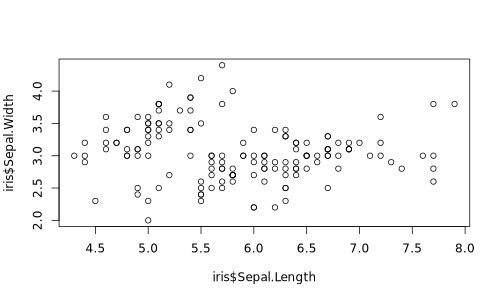

In [ ]:
%%R -w 500 -h 300 
# 画图
data(iris)
plot(iris$Sepal.Length, iris$Sepal.Width)

Error in `ggplot()`:
! `data` cannot be a function.
ℹ Have you misspelled the `data` argument in `ggplot()`
Run `rlang::last_trace()` to see where the error occurred.



Error in ggplot(data, aes(x = Sepal.Length, y = Sepal.Width, color = Species)) : 
  
ℹ Have you misspelled the `data` argument in `ggplot()`


RInterpreterError: Failed to parse and evaluate line '\nlibrary(ggplot2)\ndata(iris)\np = ggplot(data,aes(x = Sepal.Length, y = Sepal.Width, color = Species)) + geom_point(size=4)\nprint(p)\n'.
R error message: 'Error in ggplot(data, aes(x = Sepal.Length, y = Sepal.Width, color = Species)) : \n  \nℹ Have you misspelled the `data` argument in `ggplot()`'

#### lasso

In [ ]:
# code 

for age_bin in age_bin_list:
        ! echo "train_ml.py --json {age_specific_json_dir}/{age_bin}.json --train {age_specific_dataset_dir}/{age_bin}_train.pkl --test {age_specific_dataset_dir}/{age_bin}_test.pkl --out {Part4_save_path}/3_age_specific_prediction/model/{age_bin} -n 100 -t 5"